In [1]:

###############
# 1. import
#####

import pandas as pd
from datetime import datetime, timedelta
import re
import time 

# local only
import os
import cx_Oracle as oci
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:

# # DB접속 : 폴 바셋
# con_text = open("C:/Users/MAEIL/conn_MCRM.txt", 'r', encoding='utf8')
# con_text = con_text.read()


# # DB접속 : 셀렉스몰
# con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
# con_text = con_text.read()


In [8]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 통합멤버십
con_text = open("C:/Users/MAEIL/conn_CRM.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text, encoding='UTF-8', nencoding='UTF-8')

In [9]:
###############
# 1.데이터 불러오기
#####
# DB접속 : CRM
con_text = open("C:/Users/MAEIL/conn_CRM.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text, encoding='UTF-8', nencoding='UTF-8')

query = '''
        select  M.USERID
        , I.member_no
        , 2022-to_char(C.birthday, 'YYYY') as age
        , (case when C.sex in ('1', '3') then 'M' when C.sex in ('2', '4') then 'F' end) as gender
        , D.PRODUCT_CODE
        , (case when D.PRODUCT_CODE = 'P03151' then '매일두유 고단백'
                when D.PRODUCT_CODE = 'P03152' then '허쉬 프로틴'
                when D.PRODUCT_CODE = 'P00827' then '아몬드브리즈 프로틴'
                end ) as PRODUCT_NAME_GUBUN
        , D.PRODUCT_QTY as PRODUCT_COUNT
        , to_char(M.YMDD, 'YYYY-MM-DD') as PAY_DATE
        , to_char(M.YMDD, 'HH24') as PAY_TIME
        from maeil.maeil_ds_delivery M, maeil.MAEIL_DS_DELIVERY_DETAIL D, crm.customer C, crm.member I, mmbship.tm_mmb_info F
        where M.ORDERNO = D.ORDERNO
        and I.userid = M.userid
        and I.member_no = F.unfy_mmb_no
        and F.stff_dv_cd <> '1'
        and D.Product_code in ( 'P03151', 'P03152', 'P00827')
        and M.USERID = C.id(+) 
        and M.YMDD between sysdate-365 and sysdate
        '''

df_maeili = pd.read_sql(query, con = conn )


In [10]:
df_maeili.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   USERID              607 non-null    object 
 1   MEMBER_NO           607 non-null    int64  
 2   AGE                 559 non-null    float64
 3   GENDER              555 non-null    object 
 4   PRODUCT_CODE        607 non-null    object 
 5   PRODUCT_NAME_GUBUN  607 non-null    object 
 6   PRODUCT_COUNT       607 non-null    object 
 7   PAY_DATE            607 non-null    object 
 8   PAY_TIME            607 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 42.8+ KB


In [17]:
###############
# 1.데이터 불러오기
#####
# DB접속 : CRM
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

query = '''
        with buy_product as (
            select replace(수령자전화, '-', '') as cellno , 수령자명, 상품명, 배정일, to_date(배정일,'YYYYMMDD') as reg_dtm
            from lkh_emp_master
            where 수령자전화 is not null
            and length(replace(수령자전화, '-', '')) = 11 and to_date(배정일,'YYYYMMDD') between sysdate-365 and sysdate  
            and 상품명 like '%프로틴%' 
            ),
        user_info as(
            select unfy_mmb_no, mmb_nm, wrls_tel_no1 || wrls_tel_no2 || wrls_tel_no3 as cellno
            from tm_mmb_info 
            where mmb_st_cd = '1'
            )
        select U.unfy_mmb_no, B.*
        from buy_product B, user_info U, tm_mktg_recv_agrm A
        where B.cellno = U.cellno
        and B.상품명 not like '%판촉물%'
        and B.수령자명 = u.mmb_nm
        and A.unfy_mmb_no = U.unfy_mmb_no
        and A.coopco_Cd = '7010' 
        and a.sms_recv_dv_cd = '1'
        '''

df_naver = pd.read_sql(query, con = conn )

In [6]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 셀렉스
con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

###############
# 2.데이터 정렬
#####
query = '''
        select trim(I.CI) as CI
        , I.login_id as ID
        , I.name
        , to_char(sysdate, 'YYYY')-to_char(I.birth, 'YYYY') as AGE
        , I.phone_number as cellno
        , (case when U.sex in( 'W','w') then 'F' else 'M' end) as gender
        , U.REG_DATE as reg_dtm
        , round(sysdate - U.REG_DATE, 0) as time_lag
        , U.address as ADDR
        , substr(trim(u.address),1,2) as addr_lv1
        from selexfit.user_ I, userinfo U
        where I.login_id = U.id
        and I.ci is not null
        and U.sms_receive = 'Y'
        and U.sex = 'W'
        and GROUP_NAME = '일반'
        and (U.address like '%서울%' or U.address like '%경기%' or U.address like '%인천%')
        and to_char(sysdate, 'YYYY')-to_char(I.birth, 'YYYY') between 30 and 49
        and  U.REG_DATE between sysdate-40 and sysdate
        '''

df_selex = pd.read_sql(query, con = conn )


In [7]:
df_selex['GUBUN'] ='셀렉스몰'
df_maeili['GUBUN'] ='매일아이'

In [8]:
df = pd.concat([df_maeili, df_selex ], ignore_index= True)

In [9]:
len(df)

1271

In [10]:
df2 = df.drop_duplicates(subset= 'CI')

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 0 to 1270
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   CI        1271 non-null   object        
 1   ID        1271 non-null   object        
 2   NAME      1271 non-null   object        
 3   AGE       1271 non-null   int64         
 4   GENDER    1271 non-null   object        
 5   CELLNO    1271 non-null   object        
 6   REG_DTM   1271 non-null   datetime64[ns]
 7   TIME_LAG  1271 non-null   int64         
 8   ADDR      1271 non-null   object        
 9   ADDR_LV1  1271 non-null   object        
 10  GUBUN     1271 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 119.2+ KB


In [12]:
df2.REG_DTM.min()

Timestamp('2022-04-02 10:28:15')

In [17]:
# Excel 다운로드
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2 +'_PBS_targetting_rawdata.xlsx'
df3.to_excel(excel_name, sheet_name= 'Sheet1' )

In [44]:
df1 = pd.read_excel('./220628_cheese_send_list.xlsx', 0)
df2 = pd.read_excel('./220628_cheese_send_list.xlsx', 1)

In [45]:
df1['LAST_ORDER_DT'] = pd.to_datetime(df1['LAST_ORDER_DT'])
df2['LAST_ORDER_DT'] = pd.to_datetime(df2['LAST_ORDER_DT'])

df1['GUBUN'] = 'MMS_SEND'
df2['GUBUN'] = 'LMS_SEND'
df = pd.concat([df1, df2]).reset_index(drop=True)


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   MEMBER_NO      5000 non-null   int64         
 1   CUSTOMERNAME   4999 non-null   object        
 2   CELLNO         5000 non-null   object        
 3   AGE            4981 non-null   float64       
 4   LAST_ORDER_DT  5000 non-null   datetime64[ns]
 5   date_diff      5000 non-null   int64         
 6   GUBUN          5000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 273.6+ KB


In [23]:
import seaborn as sns

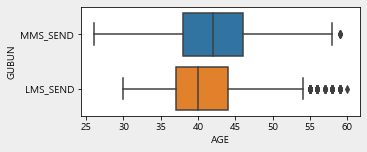

In [25]:
mpl.rc('figure', figsize=(5, 2), facecolor='#eeeeee' )
sns.boxplot(x="AGE", y="GUBUN", data=df)
# plt.title("요일 별 전체 팁의 Box Plot")
plt.show()

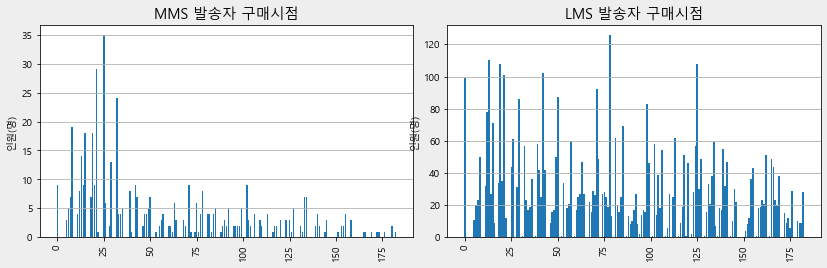

In [51]:
fig = plt.figure(figsize=(14, 18), facecolor='#eeeeee' )

# 그래프1 : 채널별 
ax3 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
# plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.bar(list(df1.date_diff.value_counts().sort_index().index), list(df1.date_diff.value_counts().sort_index()))
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.title('MMS 발송자 구매시점',fontsize='x-large')
plt.ylabel('인원(명)')

ax4 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
plt.bar(list(df2.date_diff.value_counts().sort_index().index), list(df2.date_diff.value_counts().sort_index()))
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.title('LMS 발송자 구매시점',fontsize='x-large')
plt.ylabel('인원(명)')


plt.show()

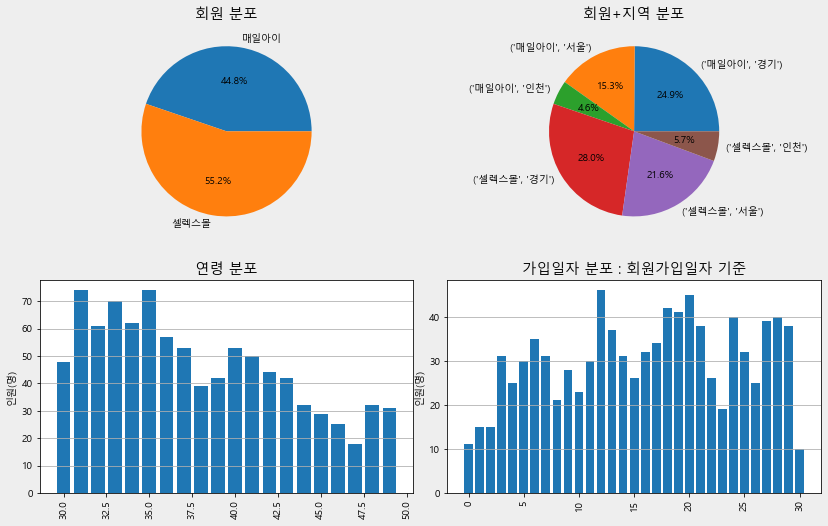

In [23]:
fig = plt.figure(figsize=(14, 18), facecolor='#eeeeee' )

# 그래프1 : 채널별 

ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2)
plt.pie(df2.groupby(['GUBUN', ])['CI'].count(), 
        labels=df2.groupby(['GUBUN', ])['CI'].count().index, autopct='%.1f%%')
# plt.legend(, loc="lower")
plt.title('회원 분포',fontsize='x-large')

ax2 = plt.subplot2grid((4, 4), (0, 2), colspan=2)
sns.boxplot(x="AGE", y="GUBUN", data=df)
plt.title('그룹별 연령 분포',fontsize='x-large')


# 그래프1 : 채널별 
ax3 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
# plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.bar(list(df2.AGE.value_counts().sort_index().index), list(df2.AGE.value_counts().sort_index()))
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.title('연령 분포',fontsize='x-large')
plt.ylabel('인원(명)')

ax4 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
# plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.bar(list(df2.TIME_LAG.value_counts().sort_index().index), list(df2.TIME_LAG.value_counts().sort_index()))
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.title('가입일자 분포 : 회원가입일자 기준',fontsize='x-large')
plt.ylabel('인원(명)')

plt.show()